In [38]:
import tensorflow as tf 
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2DTranspose,Dense,Flatten, Input ,BatchNormalization ,LeakyReLU,Reshape,Conv2D,Dropout,Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt 
from numpy.random import randint,randn
from numpy import zeros,ones
from tensorflow.keras.losses import BinaryCrossentropy


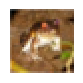

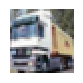

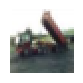

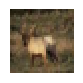

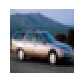

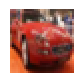

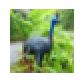

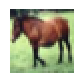

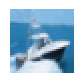

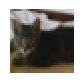

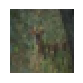

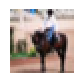

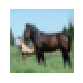

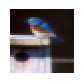

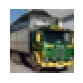

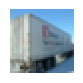

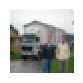

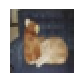

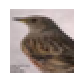

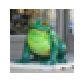

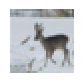

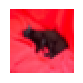

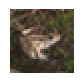

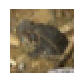

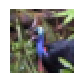

In [17]:
data=datasets.cifar10.load_data()
(trainx,trainy),(testx,testy)=data
for i in range(25):
    plt.subplot(5,5,1+i)
    plt.axis('off')
    plt.imshow(trainx[i])
    plt.show()

In [39]:
def build_discriminator(in_shape=(32,32,3)):
    model=Sequential()
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same',input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(128,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
     
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))
    
    opt=Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model 

test_discr=build_discriminator()
print(test_discr.summary())

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_27 (Conv2  (None, 32, 32, 128)       147584    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 flatten_9 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_9 (Dropout)         (None, 131072)            0         
                                                     

In [19]:
def build_generator(latent_dims):
    model =Sequential()
    n_nodes=128*8*8
    model.add(Dense(n_nodes,input_dim=latent_dims))
    model.add(LeakyReLU(alpha =0.2))
    model.add(Reshape((8,8,128)))
    
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(3,(8,8),activation='tanh',padding='same'))
    return model 
test_gener=build_generator(100)
print(test_gener.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 8192)              827392    
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_5 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_16 (Conv2  (None, 16, 16, 128)       262272    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_17 (Conv2  (None, 32, 32, 128)       262272    
 DTranspose)                                         

In [41]:
def define_gan(generator ,discriminator):
    discriminator.trainable =False
    
    model=Sequential()
    model.add(generator)
    model.add(discriminator)
    
    opt=Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt)
    return model

def load_real_samples():
    (trainx,_),(_,_)=data
    x=trainx.astype('float32')
    x=(x-127.5)/127.5
    return x 

def generate_real_samples(dataset,n_samples):
    ix =randint(0,dataset.shape[0],n_samples)
    x=dataset[ix]
    y=ones((n_samples,1))
    return x,y 

def generate_latent_points(latent_dim,n_samples):
    x_input =randn(latent_dim*n_samples)
    x_input =x_input.reshape(n_samples,latent_dim)
    return x_input 

def generate_fake_samples(generator,latent_dim,n_samples):
    x_input =generate_latent_points(latent_dim,n_samples)
    x=generator.predict(x_input)
    y=zeros((n_samples,1))
    return x,y


   

In [43]:
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=100,n_batch=128):
    bat_per_epo=int(dataset.shape[0]/n_batch)
    half_batch=int(n_batch/2 )
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            x_real,y_real=generate_real_samples(dataset,half_batch)
            d_loss1,_=d_model.train_on_batch(x_real,y_real)
            x_fake,y_fake=generate_fake_samples(g_model,latent_dim,half_batch)
            d_loss2,_=d_model.train_on_batch(x_fake,y_fake)
            
            x_gan= generate_latent_points(latent_dim,n_batch)
            y_gan=ones((n_batch,1))
            
            g_loss =gan_model.train_on_batch(x_gan,y_gan)
            
            print('Epoch>%d,Batch%d%d,d1=%.3f,d2=%.3f,g=%.3f'%
                 (i+1,j+1,bat_per_epo,d_loss1,d_loss2,g_loss))
            g_model.save('cifar_generator.h5')


In [44]:
latent_dim=100
discriminator=build_discriminator()
generator=build_generator(latent_dim)
gan_model=define_gan(generator,discriminator)
dataset=load_real_samples()

train(generator,discriminator,gan_model,dataset,latent_dim,n_epochs=2)

2/2 [==============================] - 1s 416ms/step


Epoch>1,Batch1390,d1=0.691,d2=0.736,g=0.694


C:\Users\india\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 1s 369ms/step
Epoch>1,Batch2390,d1=0.140,d2=1.063,g=0.754


2/2 [==============================] - 1s 397ms/step
Epoch>1,Batch3390,d1=0.041,d2=0.757,g=1.437


2/2 [==============================] - 1s 358ms/step
Epoch>1,Batch4390,d1=0.043,d2=0.532,g=1.091


2/2 [==============================] - 1s 392ms/step
Epoch>1,Batch5390,d1=0.046,d2=0.622,g=0.886


2/2 [==============================] - 1s 572ms/step
Epoch>1,Batch6390,d1=0.015,d2=0.634,g=0.932


2/2 [==============================] - 1s 660ms/step
Epoch>1,Batch7390,d1=0.029,d2=0.773,g=1.110


2/2 [==============================] - 1s 394ms/step
Epoch>1,Batch8390,d1=0.024,d2=0.467,g=1.596


2/2 [==============================] - 1s 480ms/step
Epoch>1,Batch9390,d1=0.090,d2=0.305,g=1.893


2/2 [==============================] - 1s 462ms/step
Epoch>1,Batch10390,d1=0.010,d2=0.208,g=2.199


2/2 [==============================] - 1s 377ms/step
Epoch>1,Batch11390,d1=0.003,d2=0.173,g=2.309


2/2 [==============================] - 1s 387ms/step
Epoch>1,Batch12390,d1=0.005,d2=0.204,g=2.614


2/2 [==============================] - 1s 387ms/step
Epoch>1,Batch13390,d1=0.001,d2=0.129,g=3.794


2/2 [==============================] - 1s 388ms/step
Epoch>1,Batch14390,d1=0.023,d2=0.054,g=3.324


2/2 [==============================] - 1s 376ms/step
Epoch>1,Batch15390,d1=0.077,d2=4.444,g=6.488


2/2 [==============================] - 1s 370ms/step
Epoch>1,Batch16390,d1=0.416,d2=0.009,g=4.817


2/2 [==============================] - 1s 382ms/step
Epoch>1,Batch17390,d1=0.093,d2=0.028,g=3.574


2/2 [==============================] - 1s 371ms/step
Epoch>1,Batch18390,d1=0.112,d2=5.370,g=3.897


2/2 [==============================] - 1s 468ms/step
Epoch>1,Batch19390,d1=0.063,d2=4.445,g=22.568


2/2 [==============================] - 1s 374ms/step
Epoch>1,Batch20390,d1=3.563,d2=0.007,g=5.182


2/2 [==============================] - 1s 375ms/step
Epoch>1,Batch21390,d1=3.380,d2=1.549,g=3.077


2/2 [==============================] - 1s 392ms/step
Epoch>1,Batch22390,d1=0.316,d2=4.237,g=5.394


2/2 [==============================] - 1s 494ms/step
Epoch>1,Batch23390,d1=0.176,d2=0.005,g=8.143


2/2 [==============================] - 1s 446ms/step
Epoch>1,Batch24390,d1=0.735,d2=1.095,g=3.112


2/2 [==============================] - 1s 373ms/step
Epoch>1,Batch25390,d1=0.265,d2=2.702,g=4.623


2/2 [==============================] - 1s 367ms/step
Epoch>1,Batch26390,d1=0.473,d2=0.012,g=5.548


2/2 [==============================] - 1s 455ms/step
Epoch>1,Batch27390,d1=0.385,d2=0.022,g=3.886


2/2 [==============================] - 1s 432ms/step
Epoch>1,Batch28390,d1=0.189,d2=0.131,g=3.189


2/2 [==============================] - 1s 377ms/step
Epoch>1,Batch29390,d1=0.154,d2=0.285,g=4.052


2/2 [==============================] - 1s 365ms/step
Epoch>1,Batch30390,d1=0.201,d2=0.036,g=3.847


2/2 [==============================] - 1s 389ms/step
Epoch>1,Batch31390,d1=0.121,d2=0.165,g=3.025


2/2 [==============================] - 1s 391ms/step
Epoch>1,Batch32390,d1=0.122,d2=0.229,g=3.903


2/2 [==============================] - 1s 454ms/step
Epoch>1,Batch33390,d1=0.123,d2=1.055,g=4.124


2/2 [==============================] - 1s 631ms/step
Epoch>1,Batch34390,d1=0.200,d2=0.886,g=3.510


2/2 [==============================] - 1s 367ms/step
Epoch>1,Batch35390,d1=0.639,d2=1.737,g=4.241


2/2 [==============================] - 1s 387ms/step
Epoch>1,Batch36390,d1=1.654,d2=2.028,g=2.124


2/2 [==============================] - 1s 374ms/step
Epoch>1,Batch37390,d1=1.330,d2=1.604,g=2.940


2/2 [==============================] - 1s 581ms/step
Epoch>1,Batch38390,d1=1.719,d2=0.644,g=2.775


2/2 [==============================] - 1s 373ms/step
Epoch>1,Batch39390,d1=1.119,d2=0.769,g=2.412


2/2 [==============================] - 1s 365ms/step
Epoch>1,Batch40390,d1=1.171,d2=0.583,g=3.769


2/2 [==============================] - 1s 363ms/step
Epoch>1,Batch41390,d1=1.148,d2=0.858,g=1.568


2/2 [==============================] - 1s 508ms/step
Epoch>1,Batch42390,d1=1.364,d2=0.304,g=3.826


2/2 [==============================] - 1s 376ms/step
Epoch>1,Batch43390,d1=0.885,d2=0.655,g=1.425


2/2 [==============================] - 1s 470ms/step
Epoch>1,Batch44390,d1=0.446,d2=1.650,g=1.315


2/2 [==============================] - 1s 419ms/step
Epoch>1,Batch45390,d1=0.465,d2=0.891,g=2.014


2/2 [==============================] - 1s 501ms/step
Epoch>1,Batch46390,d1=0.961,d2=0.520,g=1.559


2/2 [==============================] - 1s 463ms/step
Epoch>1,Batch47390,d1=0.858,d2=0.735,g=1.467


2/2 [==============================] - 1s 375ms/step
Epoch>1,Batch48390,d1=0.897,d2=0.525,g=1.935


2/2 [==============================] - 1s 370ms/step
Epoch>1,Batch49390,d1=0.844,d2=0.566,g=1.737


2/2 [==============================] - 1s 396ms/step
Epoch>1,Batch50390,d1=0.757,d2=0.577,g=1.393


2/2 [==============================] - 1s 390ms/step
Epoch>1,Batch51390,d1=0.625,d2=0.701,g=1.291


2/2 [==============================] - 1s 391ms/step
Epoch>1,Batch52390,d1=0.632,d2=0.675,g=1.473


2/2 [==============================] - 1s 460ms/step
Epoch>1,Batch53390,d1=0.697,d2=0.457,g=1.840


2/2 [==============================] - 1s 512ms/step
Epoch>1,Batch54390,d1=0.611,d2=0.646,g=1.420


2/2 [==============================] - 1s 363ms/step
Epoch>1,Batch55390,d1=0.663,d2=0.804,g=1.016


2/2 [==============================] - 1s 364ms/step
Epoch>1,Batch56390,d1=0.575,d2=0.714,g=0.994


2/2 [==============================] - 1s 393ms/step
Epoch>1,Batch57390,d1=0.542,d2=0.679,g=1.042


2/2 [==============================] - 1s 374ms/step
Epoch>1,Batch58390,d1=0.561,d2=0.629,g=1.232


2/2 [==============================] - 1s 359ms/step
Epoch>1,Batch59390,d1=0.542,d2=0.501,g=1.374


2/2 [==============================] - 1s 369ms/step
Epoch>1,Batch60390,d1=0.533,d2=0.484,g=1.371


2/2 [==============================] - 1s 356ms/step
Epoch>1,Batch61390,d1=0.531,d2=0.524,g=1.399


2/2 [==============================] - 1s 361ms/step
Epoch>1,Batch62390,d1=0.540,d2=0.713,g=1.736


2/2 [==============================] - 1s 370ms/step
Epoch>1,Batch63390,d1=0.537,d2=0.373,g=2.019


2/2 [==============================] - 1s 365ms/step
Epoch>1,Batch64390,d1=0.715,d2=0.465,g=1.935


2/2 [==============================] - 1s 364ms/step
Epoch>1,Batch65390,d1=0.742,d2=0.371,g=1.807


2/2 [==============================] - 1s 376ms/step
Epoch>1,Batch66390,d1=0.645,d2=0.548,g=2.302


2/2 [==============================] - 1s 376ms/step
Epoch>1,Batch67390,d1=0.636,d2=0.387,g=2.158


2/2 [==============================] - 1s 374ms/step
Epoch>1,Batch68390,d1=0.571,d2=0.411,g=2.283


2/2 [==============================] - 1s 357ms/step
Epoch>1,Batch69390,d1=0.698,d2=0.656,g=2.174


2/2 [==============================] - 1s 375ms/step
Epoch>1,Batch70390,d1=0.658,d2=0.478,g=2.460


2/2 [==============================] - 1s 367ms/step
Epoch>1,Batch71390,d1=0.652,d2=0.353,g=2.557


2/2 [==============================] - 1s 362ms/step
Epoch>1,Batch72390,d1=0.569,d2=0.405,g=2.033


2/2 [==============================] - 1s 363ms/step
Epoch>1,Batch73390,d1=0.475,d2=0.569,g=1.341


2/2 [==============================] - 1s 357ms/step
Epoch>1,Batch74390,d1=0.456,d2=0.734,g=1.031


2/2 [==============================] - 1s 362ms/step
Epoch>1,Batch75390,d1=0.274,d2=0.594,g=1.124


2/2 [==============================] - 1s 366ms/step
Epoch>1,Batch76390,d1=0.402,d2=0.546,g=1.215


2/2 [==============================] - 1s 364ms/step
Epoch>1,Batch77390,d1=0.288,d2=0.489,g=1.459


2/2 [==============================] - 1s 368ms/step
Epoch>1,Batch78390,d1=0.314,d2=0.399,g=1.682


2/2 [==============================] - 1s 379ms/step
Epoch>1,Batch79390,d1=0.272,d2=0.436,g=2.140


2/2 [==============================] - 1s 350ms/step
Epoch>1,Batch80390,d1=0.320,d2=0.343,g=2.520


2/2 [==============================] - 1s 373ms/step
Epoch>1,Batch81390,d1=0.343,d2=0.360,g=2.584


2/2 [==============================] - 1s 364ms/step
Epoch>1,Batch82390,d1=0.541,d2=0.542,g=2.557


2/2 [==============================] - 1s 398ms/step
Epoch>1,Batch83390,d1=0.750,d2=0.684,g=2.469


2/2 [==============================] - 1s 355ms/step
Epoch>1,Batch84390,d1=0.838,d2=0.830,g=2.465


2/2 [==============================] - 1s 368ms/step
Epoch>1,Batch85390,d1=1.250,d2=0.875,g=3.210


2/2 [==============================] - 1s 362ms/step
Epoch>1,Batch86390,d1=1.386,d2=0.298,g=3.327


2/2 [==============================] - 1s 371ms/step
Epoch>1,Batch87390,d1=0.808,d2=0.327,g=3.152


2/2 [==============================] - 1s 363ms/step
Epoch>1,Batch88390,d1=0.658,d2=0.414,g=2.485


2/2 [==============================] - 1s 361ms/step
Epoch>1,Batch89390,d1=0.700,d2=0.639,g=2.190


2/2 [==============================] - 1s 357ms/step
Epoch>1,Batch90390,d1=0.748,d2=0.546,g=2.080


2/2 [==============================] - 1s 363ms/step
Epoch>1,Batch91390,d1=0.843,d2=0.426,g=1.951


2/2 [==============================] - 1s 359ms/step
Epoch>1,Batch92390,d1=0.733,d2=0.406,g=1.796


2/2 [==============================] - 1s 358ms/step
Epoch>1,Batch93390,d1=0.750,d2=0.558,g=1.531


2/2 [==============================] - 1s 364ms/step
Epoch>1,Batch94390,d1=0.491,d2=0.501,g=1.667


2/2 [==============================] - 1s 367ms/step
Epoch>1,Batch95390,d1=0.462,d2=0.462,g=1.439


2/2 [==============================] - 1s 360ms/step
Epoch>1,Batch96390,d1=0.486,d2=0.704,g=1.179


2/2 [==============================] - 1s 377ms/step
Epoch>1,Batch97390,d1=0.354,d2=0.688,g=1.278


2/2 [==============================] - 1s 386ms/step
Epoch>1,Batch98390,d1=0.406,d2=0.672,g=1.450


2/2 [==============================] - 1s 381ms/step
Epoch>1,Batch99390,d1=0.416,d2=0.547,g=1.575


2/2 [==============================] - 1s 375ms/step
Epoch>1,Batch100390,d1=0.411,d2=0.561,g=1.717


2/2 [==============================] - 1s 382ms/step
Epoch>1,Batch101390,d1=0.432,d2=0.479,g=1.831


2/2 [==============================] - 1s 367ms/step
Epoch>1,Batch102390,d1=0.471,d2=0.621,g=2.096


2/2 [==============================] - 1s 382ms/step
Epoch>1,Batch103390,d1=0.679,d2=0.614,g=2.454


2/2 [==============================] - 1s 365ms/step
Epoch>1,Batch104390,d1=0.901,d2=0.717,g=2.132


2/2 [==============================] - 1s 469ms/step
Epoch>1,Batch105390,d1=0.868,d2=0.417,g=2.608


2/2 [==============================] - 1s 429ms/step
Epoch>1,Batch106390,d1=1.281,d2=0.526,g=1.930


2/2 [==============================] - 1s 386ms/step
Epoch>1,Batch107390,d1=0.754,d2=0.544,g=2.261


2/2 [==============================] - 1s 357ms/step
Epoch>1,Batch108390,d1=0.746,d2=0.453,g=2.325


2/2 [==============================] - 1s 380ms/step
Epoch>1,Batch109390,d1=0.748,d2=0.582,g=1.868


2/2 [==============================] - 1s 369ms/step
Epoch>1,Batch110390,d1=0.505,d2=0.742,g=2.020


2/2 [==============================] - 1s 367ms/step
Epoch>1,Batch111390,d1=0.764,d2=0.522,g=2.387


2/2 [==============================] - 1s 362ms/step
Epoch>1,Batch112390,d1=0.515,d2=0.385,g=2.067


2/2 [==============================] - 1s 409ms/step
Epoch>1,Batch113390,d1=0.384,d2=0.612,g=1.295


2/2 [==============================] - 1s 529ms/step
Epoch>1,Batch114390,d1=0.274,d2=0.598,g=1.270


2/2 [==============================] - 1s 490ms/step
Epoch>1,Batch115390,d1=0.322,d2=0.557,g=1.246


2/2 [==============================] - 1s 526ms/step
Epoch>1,Batch116390,d1=0.442,d2=0.676,g=1.225


2/2 [==============================] - 1s 410ms/step
Epoch>1,Batch117390,d1=0.383,d2=0.699,g=1.326


2/2 [==============================] - 1s 376ms/step
Epoch>1,Batch118390,d1=0.493,d2=0.952,g=1.381


2/2 [==============================] - 1s 384ms/step
Epoch>1,Batch119390,d1=0.730,d2=0.800,g=1.412


2/2 [==============================] - 1s 370ms/step
Epoch>1,Batch120390,d1=0.857,d2=0.585,g=1.554


2/2 [==============================] - 1s 366ms/step
Epoch>1,Batch121390,d1=0.674,d2=0.810,g=1.993


2/2 [==============================] - 1s 382ms/step
Epoch>1,Batch122390,d1=0.972,d2=0.458,g=2.104


2/2 [==============================] - 1s 465ms/step
Epoch>1,Batch123390,d1=0.936,d2=0.432,g=2.541


2/2 [==============================] - 1s 562ms/step
Epoch>1,Batch124390,d1=1.096,d2=0.382,g=2.348


2/2 [==============================] - 1s 472ms/step
Epoch>1,Batch125390,d1=0.808,d2=0.657,g=2.855


2/2 [==============================] - 1s 404ms/step
Epoch>1,Batch126390,d1=1.038,d2=0.475,g=2.333


2/2 [==============================] - 1s 406ms/step
Epoch>1,Batch127390,d1=0.849,d2=0.547,g=2.248


2/2 [==============================] - 1s 413ms/step
Epoch>1,Batch128390,d1=0.950,d2=0.589,g=1.984


2/2 [==============================] - 1s 416ms/step
Epoch>1,Batch129390,d1=0.745,d2=0.497,g=2.116


2/2 [==============================] - 1s 412ms/step
Epoch>1,Batch130390,d1=0.687,d2=0.490,g=1.878


2/2 [==============================] - 1s 390ms/step
Epoch>1,Batch131390,d1=0.672,d2=0.705,g=1.388


2/2 [==============================] - 1s 393ms/step
Epoch>1,Batch132390,d1=0.487,d2=0.768,g=1.293


2/2 [==============================] - 1s 454ms/step
Epoch>1,Batch133390,d1=0.708,d2=0.853,g=1.278


2/2 [==============================] - 1s 469ms/step
Epoch>1,Batch134390,d1=0.723,d2=0.670,g=1.266


2/2 [==============================] - 1s 402ms/step
Epoch>1,Batch135390,d1=0.498,d2=0.514,g=1.369


2/2 [==============================] - 1s 392ms/step
Epoch>1,Batch136390,d1=0.487,d2=0.463,g=1.333


2/2 [==============================] - 1s 369ms/step
Epoch>1,Batch137390,d1=0.430,d2=0.486,g=1.240


2/2 [==============================] - 1s 375ms/step
Epoch>1,Batch138390,d1=0.343,d2=0.666,g=1.330


2/2 [==============================] - 1s 392ms/step
Epoch>1,Batch139390,d1=0.528,d2=0.571,g=1.401


2/2 [==============================] - 1s 427ms/step
Epoch>1,Batch140390,d1=0.603,d2=0.713,g=1.134


2/2 [==============================] - 1s 513ms/step
Epoch>1,Batch141390,d1=0.623,d2=1.025,g=1.047


2/2 [==============================] - 1s 400ms/step
Epoch>1,Batch142390,d1=0.724,d2=0.696,g=1.499


2/2 [==============================] - 1s 415ms/step
Epoch>1,Batch143390,d1=0.815,d2=0.451,g=1.835


2/2 [==============================] - 1s 444ms/step
Epoch>1,Batch144390,d1=0.806,d2=0.658,g=1.621


2/2 [==============================] - 1s 412ms/step
Epoch>1,Batch145390,d1=0.807,d2=0.851,g=1.549


2/2 [==============================] - 1s 402ms/step
Epoch>1,Batch146390,d1=0.778,d2=0.464,g=2.453


2/2 [==============================] - 1s 395ms/step
Epoch>1,Batch147390,d1=0.966,d2=0.384,g=2.190


2/2 [==============================] - 1s 395ms/step
Epoch>1,Batch148390,d1=0.679,d2=0.691,g=1.535


2/2 [==============================] - 1s 410ms/step
Epoch>1,Batch149390,d1=0.812,d2=0.644,g=1.887


2/2 [==============================] - 1s 407ms/step
Epoch>1,Batch150390,d1=0.581,d2=0.240,g=2.548


2/2 [==============================] - 1s 416ms/step
Epoch>1,Batch151390,d1=0.627,d2=0.312,g=2.095


2/2 [==============================] - 1s 414ms/step
Epoch>1,Batch152390,d1=0.480,d2=0.511,g=1.431


2/2 [==============================] - 1s 435ms/step
Epoch>1,Batch153390,d1=0.518,d2=0.868,g=0.845


2/2 [==============================] - 1s 401ms/step
Epoch>1,Batch154390,d1=0.485,d2=0.926,g=1.021


2/2 [==============================] - 1s 409ms/step
Epoch>1,Batch155390,d1=0.533,d2=0.499,g=1.585


2/2 [==============================] - 1s 405ms/step
Epoch>1,Batch156390,d1=0.536,d2=0.468,g=1.671


2/2 [==============================] - 1s 397ms/step
Epoch>1,Batch157390,d1=0.495,d2=0.903,g=1.078


2/2 [==============================] - 1s 417ms/step
Epoch>1,Batch158390,d1=0.630,d2=1.052,g=1.145


2/2 [==============================] - 1s 407ms/step
Epoch>1,Batch159390,d1=0.725,d2=0.545,g=1.457


2/2 [==============================] - 1s 416ms/step
Epoch>1,Batch160390,d1=0.777,d2=0.409,g=1.631


2/2 [==============================] - 1s 415ms/step
Epoch>1,Batch161390,d1=0.620,d2=0.837,g=1.454


2/2 [==============================] - 1s 397ms/step
Epoch>1,Batch162390,d1=0.677,d2=1.326,g=1.894


2/2 [==============================] - 1s 519ms/step
Epoch>1,Batch163390,d1=0.722,d2=0.295,g=2.961


2/2 [==============================] - 1s 422ms/step
Epoch>1,Batch164390,d1=0.737,d2=0.381,g=2.362


2/2 [==============================] - 1s 406ms/step
Epoch>1,Batch165390,d1=0.663,d2=0.644,g=2.606


2/2 [==============================] - 1s 397ms/step
Epoch>1,Batch166390,d1=0.886,d2=0.639,g=2.202


2/2 [==============================] - 1s 403ms/step
Epoch>1,Batch167390,d1=0.927,d2=1.336,g=0.761


2/2 [==============================] - 1s 405ms/step
Epoch>1,Batch168390,d1=0.718,d2=1.104,g=1.329


2/2 [==============================] - 1s 393ms/step
Epoch>1,Batch169390,d1=0.621,d2=0.389,g=1.995


2/2 [==============================] - 1s 432ms/step
Epoch>1,Batch170390,d1=0.621,d2=0.350,g=1.847


2/2 [==============================] - 1s 421ms/step
Epoch>1,Batch171390,d1=0.591,d2=0.445,g=1.513


2/2 [==============================] - 1s 481ms/step
Epoch>1,Batch172390,d1=0.512,d2=0.693,g=1.154


2/2 [==============================] - 1s 421ms/step
Epoch>1,Batch173390,d1=0.410,d2=0.681,g=1.288


2/2 [==============================] - 1s 434ms/step
Epoch>1,Batch174390,d1=0.468,d2=0.675,g=1.537


2/2 [==============================] - 1s 435ms/step
Epoch>1,Batch175390,d1=0.646,d2=0.529,g=1.742


2/2 [==============================] - 1s 444ms/step
Epoch>1,Batch176390,d1=0.727,d2=0.724,g=1.520


2/2 [==============================] - 1s 538ms/step
Epoch>1,Batch177390,d1=0.863,d2=0.851,g=1.507


2/2 [==============================] - 1s 408ms/step
Epoch>1,Batch178390,d1=0.864,d2=0.603,g=1.768


2/2 [==============================] - 1s 457ms/step
Epoch>1,Batch179390,d1=0.793,d2=0.395,g=1.893


2/2 [==============================] - 1s 489ms/step
Epoch>1,Batch180390,d1=0.719,d2=0.396,g=1.851


2/2 [==============================] - 1s 507ms/step
Epoch>1,Batch181390,d1=0.540,d2=0.494,g=1.930


2/2 [==============================] - 1s 526ms/step
Epoch>1,Batch182390,d1=0.538,d2=0.663,g=1.638


2/2 [==============================] - 1s 411ms/step
Epoch>1,Batch183390,d1=0.632,d2=0.664,g=2.008


2/2 [==============================] - 1s 524ms/step
Epoch>1,Batch184390,d1=1.110,d2=0.775,g=1.290


2/2 [==============================] - 1s 432ms/step
Epoch>1,Batch185390,d1=0.842,d2=0.812,g=1.259


2/2 [==============================] - 1s 449ms/step
Epoch>1,Batch186390,d1=0.757,d2=0.502,g=1.509


2/2 [==============================] - 1s 444ms/step
Epoch>1,Batch187390,d1=0.622,d2=0.570,g=1.237


2/2 [==============================] - 1s 416ms/step
Epoch>1,Batch188390,d1=0.595,d2=0.716,g=1.135


2/2 [==============================] - 1s 410ms/step
Epoch>1,Batch189390,d1=0.646,d2=0.570,g=1.323


2/2 [==============================] - 1s 402ms/step
Epoch>1,Batch190390,d1=0.596,d2=0.433,g=1.627


2/2 [==============================] - 1s 415ms/step
Epoch>1,Batch191390,d1=0.592,d2=0.359,g=1.733


2/2 [==============================] - 1s 448ms/step
Epoch>1,Batch192390,d1=0.556,d2=0.527,g=1.537


2/2 [==============================] - 1s 549ms/step
Epoch>1,Batch193390,d1=0.668,d2=0.768,g=1.147


2/2 [==============================] - 1s 448ms/step
Epoch>1,Batch194390,d1=0.659,d2=0.804,g=1.050


2/2 [==============================] - 1s 454ms/step
Epoch>1,Batch195390,d1=0.721,d2=1.021,g=1.235


2/2 [==============================] - 1s 461ms/step
Epoch>1,Batch196390,d1=0.797,d2=0.988,g=1.854


2/2 [==============================] - 1s 415ms/step
Epoch>1,Batch197390,d1=1.076,d2=0.635,g=2.456


2/2 [==============================] - 1s 567ms/step
Epoch>1,Batch198390,d1=0.893,d2=0.487,g=1.877


2/2 [==============================] - 1s 421ms/step
Epoch>1,Batch199390,d1=0.760,d2=0.745,g=1.330


2/2 [==============================] - 1s 476ms/step
Epoch>1,Batch200390,d1=0.710,d2=0.743,g=1.283


2/2 [==============================] - 1s 416ms/step
Epoch>1,Batch201390,d1=0.627,d2=0.474,g=1.480


2/2 [==============================] - 1s 441ms/step
Epoch>1,Batch202390,d1=0.717,d2=0.536,g=1.486


2/2 [==============================] - 1s 415ms/step
Epoch>1,Batch203390,d1=0.614,d2=0.564,g=1.229


2/2 [==============================] - 1s 447ms/step
Epoch>1,Batch204390,d1=0.630,d2=0.811,g=0.975


2/2 [==============================] - 1s 529ms/step
Epoch>1,Batch205390,d1=0.593,d2=0.887,g=0.918


2/2 [==============================] - 1s 545ms/step
Epoch>1,Batch206390,d1=0.624,d2=0.833,g=0.978


2/2 [==============================] - 1s 470ms/step
Epoch>1,Batch207390,d1=0.690,d2=0.712,g=1.074


2/2 [==============================] - 1s 494ms/step
Epoch>1,Batch208390,d1=0.665,d2=0.517,g=1.247


2/2 [==============================] - 1s 588ms/step
Epoch>1,Batch209390,d1=0.596,d2=0.566,g=1.484


2/2 [==============================] - 1s 385ms/step
Epoch>1,Batch210390,d1=0.568,d2=0.614,g=1.784


2/2 [==============================] - 1s 408ms/step


KeyboardInterrupt: 

1/1 [==============================] - 1s 708ms/step


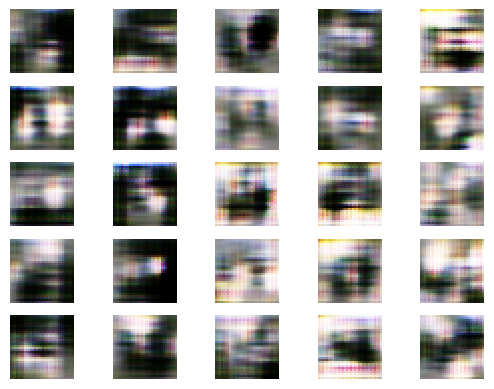

In [46]:
from keras.models import load_model
from numpy.random import randn
import numpy as np 

def show_plot(examples,n):
    for i in range(n*n):
        plt.subplot(n,n,1+i)
        plt.axis('off')
        plt.imshow(examples[i,:,:,:])
    plt.show()
    
model = load_model('cifar_generator.h5')
latent_points=generate_latent_points(100,25)
x=model.predict(latent_points)
x=(x+1)/2.0
x=(x*255).astype(np.uint8)
show_plot(x,5)
